In [28]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
category_train = {}
category_test = {}
for category in all_categories:
    category_train[category] = category_lines[category][:7*(len(category_lines)//10)]
    category_test[category] = category_lines[category][7*(len(category_lines)//10):]


['data/names/Czech.txt', 'data/names/Greek.txt', 'data/names/Dutch.txt', 'data/names/Russian.txt', 'data/names/Chinese.txt', 'data/names/Scottish.txt', 'data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Portuguese.txt', 'data/names/Japanese.txt', 'data/names/French.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Polish.txt', 'data/names/Spanish.txt', 'data/names/German.txt', 'data/names/Korean.txt']


In [12]:
import torch

def oneHotEncode(letter, nsize = n_letters):
    v = torch.zeros(1, nsize)
    v[0][all_letters.find(letter)] = 1
    return v

def wordToTensor(word, nsize = n_letters):
    tensor = torch.zeros(len(word), 1, n_letters)
    for it, c in enumerate(word):
        tensor[it][0] = oneHotEncode(c)
    return tensor

In [40]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, gate_size):
        super(LSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.gate_size = gate_size
        
        self.slinear1 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig1 = nn.Sigmoid()
        
        self.slinear2 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig2 = nn.Sigmoid()
        
        self.slinear3 = nn.Linear(input_size + hidden_size, gate_size)
        self.sig3 = nn.Sigmoid()
        
        self.tlinear1 = nn.Linear(input_size + hidden_size, gate_size)
        self.tanh1 = nn.Tanh()
        
        self.tanh2 = nn.Tanh()
        
    def forward(self, input):
        combined = torch.cat((self.Hidden, input), dim = 1)
        ft = self.slinear1(combined)
        ft = self.sig1(ft)
        
        it = self.slinear2(combined)
        it = self.sig2(it)
        
        ct = self.tlinear1(combined)
        ct = self.tanh1(ct)
        
        ot = self.slinear3(combined)
        ot = self.sig3(ot)
        
        self.Gate = ft.mul(self.Gate).add(it.mul(ct))

        self.Hidden = self.tanh2(self.Gate).mul(ot)
        
        return self.Hidden
        
    def initRecurrentLayers(self):
        self.Hidden = torch.zeros(1, self.hidden_size)
        self.Gate = torch.zeros(1, self.gate_size)
        


In [73]:

class LSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, gate_size, hidden_size2, gate_size2, output_size):
        super(LSTM2, self).__init__()
        
        self.layer1 = LSTM(input_size, hidden_size, gate_size);
        self.layer2 = LSTM(hidden_size, hidden_size2, gate_size2)

        self.linearout = nn.Linear(gate_size2, output_size)
        self.Logsoftmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input):
        output = self.layer1(input)
        output = self.layer2(output)
        
        output = self.linearout(output)
        output = self.Logsoftmax(output)
        return output
        
    def initRecurrentLayers(self):
        self.layer1.initRecurrentLayers();
        self.layer2.initRecurrentLayers();
        
lstm2 = LSTM2(n_letters, 48, 48, 32, 32, n_categories)

In [74]:
def argMax(output):
    top_i = output[0].topk(2, sorted = True) 
    ##value/index ith elemtn
    category_i = top_i[1][0].item()
    return all_categories[category_i], category_i


In [75]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = wordToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = wordToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = English / line = Abel
category = French / line = Albert
category = Spanish / line = Abaroa
category = Russian / line = Ababko
category = Greek / line = Adamou
category = English / line = Abraham
category = Vietnamese / line = Tron
category = Scottish / line = Campbell
category = Irish / line = Ahearn
category = Chinese / line = Ang


In [80]:
import torch.optim as optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(lstm.parameters(), lr = 0.01)

In [77]:
def train(category_tensor, line_tensor):
    lstm2.initRecurrentLayers()

    optimizer.zero_grad()
    for i in range(line_tensor.size()[0]):
        output= lstm2(line_tensor[i])

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [ ]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000
torch.set_num_threads(4)



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = argMax(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        print('%d: %.4f'%(iter, current_loss/plot_every))
        current_loss = 0

1000: 2.8942
2000: 2.8929
3000: 2.8987
4000: 2.8936
5000 5% (0m 42s) 2.9570 Aarle / Portuguese ✗ (Dutch)
5000: 2.8978
6000: 2.8944
7000: 2.8945
8000: 2.8971
9000: 2.8907
10000 10% (1m 24s) 2.9210 Andrysiak / Portuguese ✗ (Polish)
10000: 2.8915
11000: 2.8927
12000: 2.8949
13000: 2.8975
14000: 2.8985
15000 15% (2m 7s) 2.8755 Ban / Portuguese ✗ (Chinese)
15000: 2.8940
16000: 2.8940
17000: 2.8934
18000: 2.8939
19000: 2.8942


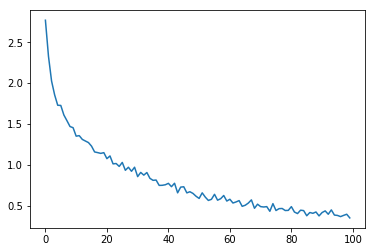

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

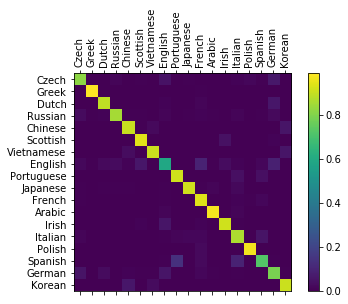

0.8808


In [12]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000
n_correct = 0
# Just return an output given a line
def evaluate(line_tensor):
    hidden = lstm.initRecurrentLayers()

    for i in range(line_tensor.size()[0]):
        output = lstm(line_tensor[i])

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = argMax(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    if(category_i == guess_i):
        n_correct += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print(n_correct/n_confusion)

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(wordToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')